In [1146]:
import pandas as pd
import numpy as np
import math
import itertools
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from pathlib import Path
from sklearn.preprocessing import scale, normalize, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeClassifier, LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression
from sklearn import svm
import lightgbm as lgb
from copy import deepcopy
import pydotplus
from IPython.display import Image
from category_encoders import OrdinalEncoder, CountEncoder, TargetEncoder
pd.options.mode.chained_assignment = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [751]:
# Helper functions
def series_check(convert_): # DONE
    if isinstance(convert_, pd.DataFrame):
        return convert_.iloc[:,0]
    elif isinstance(convert_, np.ndarray):
        return pd.Series(onedim_check(convert_))
    elif not isinstance(convert_, pd.Series):
        return pd.Series(convert_)
    else:
        return convert_
    
def dataframe_check(convert_): # DONE
    if isinstance(convert_, pd.Series):
        return convert_.to_frame()
    elif not isinstance(convert_, pd.DataFrame):
        return pd.DataFrame(convert_)
    else:
        return convert_

def onedim_check(convert_): # DONE
    if isinstance(convert_, np.ndarray):
        if convert_.ndim == 1:
            return convert_
        return convert_.flatten()
    return np.array(convert_).flatten()

def twodim_check(convert_): # DONE
    if isinstance(convert_, np.ndarray):
        if convert_.ndim == 2:
            return convert_
        return convert_.reshape(1, convert_.size)
    elif isinstance(convert_, pd.Series):
        return np.array(convert_).reshape(convert_.shape[0], 1)
    elif isinstance(convert_, pd.DataFrame):
        return np.array(convert_)
    new_arr = np.array(convert_)
    if new_arr.ndim == 2:
        return new_arr
    return new_arr.reshape(1, new_arr.size)

def plt_settings(width_, height_):
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(width_, height_))
    return fig, ax
    
def col_oper_(column_, oper_): # DONE
    series_check(column_)
    oper_ = oper_.lower()
    if oper_=="mean":
        return column_.mean()
    elif oper_=="median":
        return column_.median()
    elif oper_=="mode":
        return stats.mode(column_)[0][0]
    elif oper_=="std":
        return column_.std()
    elif oper_=="min":
        return column_.min()
    elif oper_=="max":
        return column_.max()
    elif oper_=="range":
        return column_.max()-column_.min()
    elif oper_=="25":
        return column_.describe()["25%"]
    elif oper_=="75":
        return column_.describe()["75%"]
    else:
        raise ValueError("No such operation")


In [549]:
def find_null(df_): # DONE
    '''
    Returns a dictionary of indices with null values for every column in a DataFrame.
    
    Parameters:
        df_ : Series, DataFrame, list or array-like
    Returns
        nulls_ : Dictionary
    '''
    df_ = dataframe_check(df_)
    nulls_ = {}
    for col in df_.columns:
        null_indices = df_[col].loc[df_[col].isnull()].index.values.tolist()
        nulls_[col] = null_indices
        
    return nulls_

In [550]:
def drop_null_rows(df_, max_null=0): # DONE
    '''
    Drop rows with null count above {max_null} across all columns of {df_}.
    
    Parameters:
        df_ : Series, DataFrame, list or array-like
        max_null : int or float, optional
            Max number/percent of null values allowed in every row. Default is 0.
    Returns:
        df_ : DataFrame
    '''
    df_ = dataframe_check(df_)
    df_cols = df_.shape[1]
    if isinstance(max_null, int):
        thresh_ = df_cols-max_null
    elif max_null <= 1.0 and max_null >= 0.0:
        thresh_ = df_cols-int(df_cols*max_null)
    else:
        raise TypeError(f'{max_null} of wrong type or out of range')
    return df_.dropna(axis=0, thresh=thresh_)
    

In [551]:
def drop_null_cols(df_, max_null=0): # DONE
    '''
    Drop columns with null values above a threshold if specified.
    
    Parameters:
        df_ : Series, DataFrame, list or array-like
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}.
            Default is 0.
    Returns:
        df_ : DataFrame
    '''
    df_ = dataframe_check(df_)
    df_rows = df_.shape[0]
    if isinstance(max_null, int):
        thresh_ = df_rows-max_null
    elif max_null <= 1.0 and max_null >= 0.0:
        thresh_ = df_rows-int(df_rows*max_null)
    else:
        raise TypeError(f'{max_null} of wrong type or out of range')
    return df_.dropna(axis=1, thresh=thresh_)

In [552]:
def merge_rows(df_1, df_2): # DONE
    '''
    Merge 2 dataframes vertically by concatenating rows.
    
    Parameters:
        df_1 : Series, DataFrame, list or array-like
        df_2 : Series, DataFrame, list or array-like
    Returns:
        merged_df : DataFrame
    '''
    df_1 = dataframe_check(df_1)
    df_2 = dataframe_check(df_2)
    merged_df = pd.concat([df_1, df_2], axis=0)
    return merged_df

In [553]:
def merge_cols(df_1, df_2, join_="inner"): # DONE
    '''
    Merge 2 dataframes horizontally by concatenating columns.
    
    Parameters:
        df_1 : Series, DataFrame, list or array-like
        df_2 : Series, DataFrame, list or array-like
        join_ : str, optional
            Type of join to perform between the dataframes. Options: inner or outer.
    Returns:
        merged_df : DataFrame
    '''
    df_1 = dataframe_check(df_1)
    df_2 = dataframe_check(df_2)
    merged_df = pd.concat([df_1, df_2], axis=1, join=join_)
    return merged_df

In [554]:
def fill_null(column_, const_=0, oper_=""): # Done
    '''
    Fill null in {column_} with {const_} or a transformation of {column_} through {oper}.
    
    Parameters:
        column_ : Series, DataFrame, list or array-like
            Column with null values to replace.
        const_ : constant, optional
            Value to replace null in {column_} with. Default is 0.
        oper_ : str, optional
            Replaces null values in {column_} with the operation specified
            for non-null in {oper_}.
            Options: mean, median, mode, std, min, max, range, 25, 75
    Returns:
        column_filled_ : Series
    '''
    if not oper_:
        column_filled_ = series_check(column_)
        column_filled_ = column_filled_.fillna(const_)
    else:
        column_filled_ = column_.fillna(col_oper_(column_, oper_))
    return column_filled_

In [555]:
def fill_null_from_col(column_, column_two_, oper_=""): # Done
    '''
    Fill null in {column_} with {column_two_} or a transformation of {column_two_} through {oper}.
    
    Parameters:
        column_ : Series, DataFrame, list or array-like
            Column with null values to replace.
        column_two_ : Series, DataFrame, list or array-like
            Column to replace null values in {column_}.
        oper_ : str, optional
            Replaces null values in {column_} with a transformation of {column_two_}
            using the operation {oper_}.
            Options: mean, median, mode, std, min, max, range, 25, 75
    Returns:
        column_filled_ : Series
    '''
    column_filled_ = deepcopy(series_check(column_))
    column_two_ = series_check(column_two_)
    if not oper_:
        try:
            column_filled_.loc[column_filled_.isnull()] = list(column_two_)
        except ValueError:
            raise ValueError(f"Can't set length of {column_two_.shape[0]} to index of length {len(column_.loc[column_.isnull()])}")
    else:
        column_filled_ = column_filled_.fillna(col_oper_(column_two_, oper_))
    return column_filled_

In [556]:
def fill_null_predict(dataframe_, feature_to_fill_): # Done
    '''
    Fill null in {feature_to_fill_} with predicted values from {dataframe_}.
    
    Parameters:
        dataframe_ : DataFrame or 2-dimensional array
            Dataframe with feature and label values to train Linear Regression model.
        feature_to_fill_ : str
            Column name in {dataframe_} with null values to replace.
    Returns:
        dataframe_ : DataFrame
    '''
    dataframe_ = dataframe_check(dataframe_)
    linreg = LinearRegression()
    notnull_df_ = dataframe_.dropna()
    train_x = notnull_df_.drop(columns=[feature_to_fill_])
    train_y = notnull_df_[feature_to_fill_]
    linreg.fit(train_x, train_y)
    test_y = linreg.predict(dataframe_.drop(columns=[feature_to_fill_]))
    filled_feature_ = dataframe_[feature_to_fill_].fillna(pd.Series(test_y))
    return filled_feature_

In [557]:
def category_encode(column_, encoder_type="ordinal", target_column=None): # DONE
    '''
    Transform categorical variables into integers through encoding.
    
    Parameters:
        column_ : Series, DataFrame, list or array-like
            Column to encode.
        encoder_type : str, optional
            Method of encoding {column_}.
            Options: onehot, ordinal, count, or target. Default is ordinal.
        target_column : Series, DataFrame, list or array-like
            Target column, only used with TargetEncoder.
    Returns:
        df_ : DataFrame
    '''
    column_ = series_check(column_)
    if target_column:
        target_column = series_check(target_column)
    encoder_type = encoder_type.lower()
    if encoder_type=="onehot":
        return pd.get_dummies(column_)
    if encoder_type=="ordinal":
        return OrdinalEncoder().fit_transform(column_)
    elif encoder_type=="count":
        return CountEncoder().fit_transform(column_)
    elif encoder_type=="target":
        return TargetEncoder().fit_transform(column_, target_column)
    else:
        raise ValueError

In [940]:
def transform(df_, transform_="standardize"): # DONE
    '''
    Transforms values in {df_}.
    Defaults to standardizing all columns.
            
    Parameters:
        df_ : Series, DataFrame, list or array-like
            Data to transform.
        transform_ : str, optional
            Transformation to apply to column. Default is standardize.
            Options: standardize, normalize, log, cuberoot, squareroot, cube, or square.
    Returns:
        Series
    '''
    transform_ = transform_.lower()
    if transform_=="standardize":
        return scale(df_)
    elif transform_=="normalize":
        scaler = MinMaxScaler()
        return scaler.fit_transform(df_)
    elif transform_=="log":
        return np.log1p(df_)
    elif transform_=="cuberoot":
        return np.cbrt(df_)
    elif transform_=="squareroot":
        return np.sqrt(df_)
    elif transform_=="cube":
        return np.power(df_, 3)
    elif transform_=="square":
        return np.square(df_)
    else:
        raise ValueError
        

In [657]:
def bucket(column_, bins_, bin_labels_=None): # DONE
    '''
    Buckets data in specified column.
    
    Parameters:
        column_ : Series, DataFrame, list or array-like
            Data to put into buckets.
        bins_ : int, IntervalIndex, list or array-like
            Values to provide edges for buckets. If int, bucket edges will be automatically set.
        bin_labels_ : list, boolean, optional
            Labels of bins, must be the same length as {bins_}. If set to False, won't return labels
            and will only include integer indicators of the bins. If None, returns the labels.
            Default is None.
    Returns:
        Returns Series object of bucket labels corresponding to the values in {column_}.
    '''
    column_ = onedim_check(column_)
    binned_ = pd.cut(column_, bins_, labels=bin_labels_)
    return series_check(binned_)

In [704]:
def clip_outliers(df_, z_thresh=3, value_thresh=None, direction="both"): # DONE
    '''
    Clips observations considered to be outlier.
            
    Parameters:
        df_ : DataFrame or 2-dimensional array
        z_thresh : int, float, optional
            The threshold of standard deviations beyond which outliers will be clipped.
            Defaults to 3.
        value_thresh : int, float, optional
            The value beyond which outliers will be clipped.
        direction : str
            Indicates which direction to clip outliers from.
            Options: top, bottom, or both. Defaults to both.
    Returns:
        df_ : DataFrame
    '''
    df_ = dataframe_check(df_)
    direction = direction.lower()
    if value_thresh:
        for col_ in df_.columns:
            if direction == 'top':
                df_.loc[df_[col_]>value_thresh,[col_]] = value_thresh
            elif direction == 'bottom':
                df_.loc[df_[col_]<value_thresh,[col_]] = value_thresh
            elif direction == 'both':
                raise ValueError("Direction cant be BOTH if value_thresh is passed")
    else:
        for col_ in df_.columns:
            outlier_thresh_upper = df_[col_].mean() + z_thresh * df_[col_].std()
            outlier_thresh_lower = df_[col_].mean() - z_thresh * df_[col_].std()
            if direction == 'top':
                df_.loc[df_[col_]>outlier_thresh_upper,[col_]] = outlier_thresh_upper
            elif direction == 'bottom':
                df_.loc[df_[col_]<outlier_thresh_lower,[col_]] = outlier_thresh_lower
            elif direction == 'both':
                df_.loc[df_[col_]>outlier_thresh_upper,[col_]] = outlier_thresh_upper
                df_.loc[df_[col_]<outlier_thresh_lower,[col_]] = outlier_thresh_lower
    return df_

In [750]:
def drop_outliers(df_, z_thresh=3, value_thresh=None, direction="both"): # DONE
    '''
    Drops observations considered to be outliers.
            
    Parameters:
        df_ : DataFrame or 2-dimensional array
        z_thresh : int, float, optional
            The threshold of standard deviations beyond which outliers will be dropped.
            Defaults to 3.
        value_thresh : int, float, optional
            The value beyond which outliers will be dropped.
        direction : str
            Indicates which direction to drop outliers from.
            Options: top, bottom, or both. Defaults to both.
    Returns:
        df_ : DataFrame
    '''
    df_ = dataframe_check(df_)
    direction = direction.lower()
    outliers_ = []
    if value_thresh:
        for col_ in df_.columns:
            if direction == 'top':
                df_ = df_.loc[df_[col_] < value_thresh]
            elif direction == 'bottom':
                df_ = df_.loc[df_[col_] > value_thresh]
            elif direction == 'both':
                raise ValueError("Direction cant be BOTH if value_thresh is passed")
    else:
        for col_ in df_.columns:
            z_col_ = stats.zscore(df_[[col_]], nan_policy="omit")
            if direction == 'top':
                df_ = df_.loc[z_col_ < z_thresh]
            elif direction == 'bottom':
                df_ = df_.loc[z_col_ > -1*z_thresh]
            elif direction == 'both':
                df_ = df_.loc[abs(z_col) < z_thresh]
    return df_

In [759]:
def corr_matrix(df_, method_="pearson"): # DONE
    '''
    Displays and returns a correlation matrix for the DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        method_ : str
            Method of correlation.
            Options: pearson, kendall, or spearman. Default is pearson.
    Returns:
        df_corr : DataFrame
    '''
    df_ = dataframe_check(df_)
    fig, ax = plt_settings(9, 6)
    df_corr = df_.corr(method=method)
    mask = np.zeros_like(np.array(df_corr))
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df_corr, mask=mask, annot=True)
    
    return df_corr

In [770]:
def box_plot(df_, standardize_=False): # DONE
    '''
    Displays a boxplot for the DataFrame along with relevant information.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        standardize_ : bool, optional
            Standardizes {df_} before plotting. Default is False.
    Returns:
        columns_data : Dict
    '''
    df_ = dataframe_check(df_)
    fig, ax = plt_settings(9, 6)
    if standardize_:
        df_ = pd.DataFrame(scale(df_), columns=df_.columns)
    ax = sns.boxplot(data=df_, orient="v", fliersize=2)
    columns_data = {}
    for col in df_.columns:
        col_data = {} 
        col_data["Max"] = df_[col].max()
        col_data["75%"] = df_[col].describe()["75%"]
        col_data["50%"] = df_[col].median()
        col_data["25%"] = df_[col].describe()["25%"]
        col_data["Min"] = df_[col].min()
        col_data["Top_IQR"] = df_[col].std()*1.5 + col_data["75%"]
        col_data["Bottom_IQR"] = col_data["25%"] - df_[col].std()*1.5
        outliers_top = df_[df_[col] > col_data["Top_IQR"]][col]
        outliers_bottom = df_[df_[col] < col_data["Bottom_IQR"]][col]
        col_data["Top_Outliers"] = outliers_top.index.values
        col_data["Bottom_Outliers"] = outliers_bottom.index.values
        if (len(outliers_top) == 0):
            col_data["Top_IQR"] = col_data["Max"]
        if (len(outliers_bottom == 0)):
            col_data["Bottom_IQR"] = col_data["Min"]
        columns_data[col] = col_data
        
    return columns_data

In [835]:
def scatter_matrix(df_, cols_=None, hue_=None): # DONE
    '''
    Displays a scatter matrix of specified variables.
            
    Parameters:
        df_ : DataFrame or 2-dimensional array
        cols_ : list or array-like, optional
            Column variables for scatter matrix. Default is all columns.
    '''
    df_ = dataframe_check(df_)
    if not cols_:
        cols_ = df_.columns
    g = sns.pairplot(data=df_, vars=cols_, hue=hue_)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)

In [836]:
def dist_matrix(df_, cols_=None):
    '''
    Displays a series of distribution plots for the specified variables.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        cols_ : list or array-like, optional
            Columns to place on the x-axis.
    '''
    df_ = dataframe_check(df_)
    if not isinstance(cols_, list):
        cols_ = list([cols_])
    if not cols_:
        cols_ = df_.columns.values
    num_of_plots = len(cols_)
    fig, axes = plt.subplots(nrows=(math.ceil(num_of_plots/2) if num_of_plots>2 else 1),
                             ncols=(2 if num_of_plots>1 else 1), figsize=(14, 10))
    if num_of_plots==1:
        axes = np.array(axes)
    axes = axes.ravel()
    if num_of_plots>1 and num_of_plots%2==1:
        axes[-1].set_visible(False)
    palette = itertools.cycle(sns.color_palette())
    for axis_num_, col_ in enumerate(cols_):
        col_mean = round(df_[col_].mean(), 2)
        col_std = round(df_[col_].std(), 2)
        col_max = round(df_[col_].max(), 2)
        col_min = round(df_[col_].min(), 2)
        column_ = df_[[col_]]
        bw_ = np.power(len(column_), -1./(5))
        my_plt = sns.distplot(column_, color=next(palette), kde_kws={"bw" : bw_}, ax=axes[axis_num_])
        legend_ = my_plt.legend([f'Mean: {col_mean} \nStd: {col_std} \nRange: [{col_min},{col_max}]'], loc='best')

In [850]:
def graph(df_, x_, y_=None, type_=0, hue_=None): # DONE
    '''
    Displays a distribution from {df_}.
    Depending on the type of variables, different distributions will be plotted.
    Countplot for 1 variable.
    Heatmap for 2 categorical variables.
    Swarmplot for 1 categorical and 1 numeric variable.
    Scatterplot for 2 numeric variables.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        x_ : str
            x variable corresponding to column name in {df_}
        y_ : str, optional
            y variable corresponding to column name in {df_}
        type_ : int
            Type of data plotting. Options: 0, (categorical vs categorical),
            1 (categorical vs numeric) or 2 (numeric vs numeric). Default is 0
        hue_ : str, optional
            Variable for separating data by color. Not used if type=1
    Returns:
    '''
    df_ = dataframe_check(df_)
    fig, ax = plt.subplots(figsize=(24, 10))
    if not y_:
        if hue:
            ax = sns.countplot(x=x_, hue=hue_, data=df_)
        else:
            ax = sns.countplot(x=x_, data=df_)
    else:
        if type_==0:
            sns.set(font_scale=1.6)
            plt.xlabel(x_, fontsize=30)
            plt.ylabel(y_, fontsize=30)
            df_ = pd.DataFrame(df_[[x_, y_]].groupby([x_, y_]).size())
            df_ = df_.reset_index().pivot(columns=x_, index=y_, values=df_.columns[-1])
            df_.rename(columns={"0": "Values"})
            df_.fillna(0, inplace=True)
            ax = sns.heatmap(df_, annot=True, fmt='g')
        elif type_==1:
            if hue_:
                ax = sns.swarmplot(x=x_, y=y_, hue=hue_, dodge=True, data=df_)
            else:
                ax = sns.swarmplot(x=x_, y=y_, dodge=True, data=df_)
        elif type_==2:
            if hue_:
                sns.scatterplot(x=x_, y=y_, data=df_, hue=hue_)
            else:
                sns.scatterplot(x=x_, y=y_, data=df_)

In [1056]:
def variance_threshold(feat_, thresh_=0, normalize_=False): # DONE
    '''
    Drops columns in {feat_} with a variance below {thresh_}.
    
    Parameters:
        feat_ : DataFrame or 2d array-like
            Feature columns that will be dropped from
        thresh_ : float
            Minimum variance below which a column will be dropped
        normalize_ : bool
            Normalizes {feat_} before checking variances. Default is False.
    Returns:
        df_thresh : DataFrame
            DataFrame with low variance column(s) dropped
    '''
    if normalize_:
        feat_.iloc[:, :] = transform(feat_, "normalize")
    selector = VarianceThreshold(thresh_)
    df_thresh = selector.fit(feat_)
    var_np = np.array(df_thresh.variances_)
    var_np[var_np > thresh_] = True
    var_np[var_np <= thresh_] = False
    cols_ = np.array(feat_.columns.values)[var_np.astype(bool)]
    df_thresh = selector.transform(feat_)
    df_thresh = pd.DataFrame(data=df_thresh, columns=cols_)
    return df_thresh

In [1144]:
def best_features_classif(feat_, label_, top_=2):
    '''
    Finds the top {top_} features in {feat_} for each scoring function  for a classification {label_}.
    
    Parameters:
        feat_ : DataFrame or 2d array-like
            Feature columns that will be selected from
        label_ : Series or 1d array-like
            x variable corresponding to column name in {df_}
        top_ : int
            Best number of features to select from {feat_}
    Returns:
    '''
    feat_names = feat_.columns.values
    def final_feat(transformed):
        idx_top_feat = (-transformed.scores_).argsort()[:top_]
        name_top_feat = np.array(feat_names)[idx_top_feat]
        score_top_feat = np.array(transformed.scores_)[idx_top_feat]
        final_features = {}
        for feat_, score_ in zip(name_top_feat, score_top_feat):
            final_features[feat_] = round(score_, 2)
        return final_features  
    selector_f_classif = SelectKBest(f_classif, k=top_).fit(feat_, label_)
    print("ANOVA/F-value")
    print('Selected features: {}'.format(final_feat(selector_f_classif)))
    selector_chi2 = SelectKBest(chi2, k=top_).fit(feat_, label_)
    print("Chi-Squared")
    print('Selected features: {}'.format(final_feat(selector_chi2)))
    selector_mic = SelectKBest(mutual_info_classif, k=top_).fit(feat_, label_)
    print("Mutual Information")
    print('Selected features: {}'.format(final_feat(selector_mic)))

In [1145]:
def best_features_reg(feat_, label_, top_=2):
    '''
    Finds the top {top_} features in {feat_} for each scoring function for a regression {label_}.
    
    Parameters:
        feat_ : DataFrame or 2d array-like
            Feature columns that will be selected from
        label_ : Series or 1d array-like
            x variable corresponding to column name in {df_}
        top_ : int
            Best number of features to select from {feat_}
    Returns:
    '''
    feat_names = feat_.columns.values
    def final_feat(transformed):
        idx_top_feat = (-transformed.scores_).argsort()[:top_]
        name_top_feat = np.array(feat_names)[idx_top_feat]
        score_top_feat = np.array(transformed.scores_)[idx_top_feat]
        final_features = {}
        for feat_, score_ in zip(name_top_feat, score_top_feat):
            final_features[feat_] = round(score_, 2)
        return final_features  
    selector_f_reg = SelectKBest(f_regression, k=top_).fit(feat_, label_)
    print("ANOVA/F-value")
    print('Selected features: {}'.format(final_feat(selector_f_reg)))
    selector_mic = SelectKBest(mutual_info_regression, k=top_).fit(feat_, label_)
    print("Mutual Information")
    print('Selected features: {}'.format(final_feat(selector_mic)))

In [1178]:
def ridge_classif(feat_, label_):
    solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    for solver_ in solvers:
        for alpha_ in [0.0001, 0.001, 0.01, 0.1, 1.0]:
            print(f'Solver: {solver_} Alpha: {alpha_}')
            clf = RidgeClassifier(solver=solver_, alpha=alpha_).fit(feat_, label_)
            print(f'Score: {clf.score(feat_, label_)}')

In [1193]:
def logit_classif(feat_, label_):
    solve_penalty = {
        "newton-cg" : ["l2", "none"],
        "lbfgs" : ["l2", "none"],
        "liblinear" : ["l1", "l2"],
        "sag" : ["l2", "none"],
        "saga" : ["l1", "l2", "elasticnet", "none"],
    }
    for solver_, penalties in solve_penalty.items():
        for penalty_ in penalties:
            print(f'Solver: {solver_} Penalty: {penalty_}')
            clf = LogisticRegression(solver=solver_, penalty=penalty_, l1_ratio=0.5).fit(feat_, label_)
            print(f'Score: {clf.score(feat_, label_)}')
            print("--------------------------------------")

In [1194]:
#wine_df = pd.read_csv('../WineData.csv')
#wine_df = wine_df.drop("Link", 1)
#wine_df.describe(include=['O'])
#wines_data = load_wine()
#wine_feat_ = pd.DataFrame(wines_data["data"], columns=wines_data["feature_names"])
#wine_labels_ = pd.DataFrame(load_wine()["target"], columns=["Label"])
#wine_feat_.info()
titanic_df = pd.read_csv('../train.csv')
print(titanic_df.info())
titanic_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [1195]:
embarked_null = find_null(titanic_df["Embarked"])["Embarked"]
titanic_df = titanic_df.drop(index=embarked_null)
titanic_df = titanic_df.drop(columns=["Cabin"])
#titanic_df = drop_null_rows(titanic_df, 0)
#drop_null_cols(titanic_df, 1)
#merge_rows(titanic_df[:5], titanic_df[2:7])
#merge_cols(titanic_df, titanic_df["Embarked"][:5], "outer")
#fill_null(titanic_df["Age"], 3)
#fill_null_from_col(titanic_df["Age"], [1, 2, 3], "mean")

titanic_df["Age"] = fill_null_predict(titanic_df[["Age", "Survived", "Pclass", "SibSp", "Parch"]], "Age")
titanic_df["Sex"] = category_encode(titanic_df["Sex"], "ordinal")
titanic_df["Embarked"] = category_encode(titanic_df["Embarked"], "ordinal")
#transform(titanic_df["Pclass"], "cube")
#bucket(titanic_df["Age"], [0, 25, 50, 75, 100])

#dict_ = box_plot(titanic_df[["Age"]])
#display(clip_outliers_box(titanic_df[["Age"]], dict_, "Top")[30:35])
#temp_ = drop_outliers(titanic_df[["Age"]], direction="bottom", value_thresh=1)
#corr_ = corr_matrix(titanic_df[["Age", "Survived", "Pclass", "Sex", "SibSp"]])
#box_plot_ = box_plot(titanic_df[["Age", "Survived", "Pclass", "SibSp"]], True)
#scatter_matrix(titanic_df, ["Age", "Pclass"], "Sex")
#dist_matrix(titanic_df, ["Parch", "Pclass"])
#graph(titanic_df, "Pclass", "Age", 1, "Survived")

#variance_threshold(titanic_df[["Pclass", "Age", "Fare", "SibSp"]], 0.03, True)
#best_features_classif(titanic_df[["Pclass", "Age", "Fare", "SibSp"]], titanic_df["Survived"])
#best_features_reg(titanic_df[["Pclass", "Age", "SibSp"]], titanic_df["Fare"])

#ridge_classif(titanic_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]], titanic_df["Survived"])
logit_classif(titanic_df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]], titanic_df["Survived"])
display(titanic_df)

Solver: newton-cg Penalty: l2
Score: 0.7930258717660292
--------------------------------------
Solver: newton-cg Penalty: none
Score: 0.7919010123734533
--------------------------------------
Solver: lbfgs Penalty: l2
Score: 0.7941507311586051
--------------------------------------
Solver: lbfgs Penalty: none
Score: 0.7919010123734533
--------------------------------------
Solver: liblinear Penalty: l1
Score: 0.7952755905511811
--------------------------------------
Solver: liblinear Penalty: l2
Score: 0.7986501687289089
--------------------------------------
Solver: sag Penalty: l2
Score: 0.7007874015748031
--------------------------------------
Solver: sag Penalty: none
Score: 0.7007874015748031
--------------------------------------
Solver: saga Penalty: l1
Score: 0.6929133858267716
--------------------------------------
Solver: saga Penalty: l2


C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))
C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Score: 0.6940382452193475
--------------------------------------
Solver: saga Penalty: elasticnet
Score: 0.6929133858267716
--------------------------------------
Solver: saga Penalty: none
Score: 0.6929133858267716
--------------------------------------


C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))
C:\Users\ParthivNaresh\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.000000,1,0,PC 17599,71.2833,2
2,3,1,3,"Heikkinen, Miss. Laina",2,26.000000,0,0,STON/O2. 3101282,7.9250,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.000000,1,0,113803,53.1000,1
4,5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,0,0,211536,13.0000,1
887,888,1,1,"Graham, Miss. Margaret Edith",2,19.000000,0,0,112053,30.0000,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,29.270782,1,2,W./C. 6607,23.4500,1
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,111369,30.0000,2


In [278]:
wine_df["PriceBucket"] = bucket(wine_df, "Price", [0, 5, 10, 15, 20, 30, 50, 100, 200, 100000], ["Extreme Value", "Value", "Popular Premium", "Premium", "Super Premium", "Ultra Premium", "Luxury", "Super Luxury", "Icon"])
wine_df[11445:11462]

,ID,Wine,Region,Subregion,Appellation,Vineyard,Grape,Score,Popularity,Price,Country,PriceBucket
11445,11445,"Domaine Fournillon Les Fourneaux, Chablis Prem...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Fourneaux,Chardonnay,NaN,209333,26,France,Super Premium
11446,11446,"Chateau de Fleys Les Fourneaux, Chablis Premie...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Fourneaux,Chardonnay,89.0,230079,17,France,Premium
11447,11447,"Verget Les Fourneaux, Chablis Premier Cru, France",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Fourneaux,Chardonnay,88.0,230079,54,France,Luxury
11448,11448,"Domaine Daniel-Etienne Defaix Les Lys, Chablis...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,89.0,8357,41,France,Ultra Premium
11449,11449,"Albert Bichot Domaine Long-Depaquit Les Lys, C...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,89.0,23581,32,France,Ultra Premium
11450,11450,"William Fevre Les Lys, Chablis Premier Cru, Fr...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,91.0,34869,39,France,Ultra Premium
11451,11451,"Domaine Vincent Dampt Les Lys, Chablis Premier...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,89.0,35275,26,France,Super Premium
11452,11452,"La Chablisienne Les Lys, Chablis Premier Cru, ...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,90.0,62673,25,France,Super Premium
11453,11453,"Domaine Daniel Dampt et Fils Les Lys, Chablis ...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,90.0,85555,32,France,Ultra Premium
11454,11454,"Domaine Buisson-Charles Les Lys, Chablis Premi...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,NaN,87999,43,France,Ultra Premium


In [279]:
wine_df.describe()

,ID,Score,Popularity,Price
count,56176.000000,34739.000000,56176.000000,56176.000000
mean,28087.500000,89.041797,104708.045767,67.899690
std,16216.758698,1.698768,76282.175140,630.381458
min,0.000000,81.000000,11.000000,1.000000
25%,14043.750000,88.000000,37044.000000,13.000000
50%,28087.500000,89.000000,93442.000000,22.000000
75%,42131.250000,90.000000,168129.000000,42.000000
max,56175.000000,97.000000,257118.000000,99916.000000


In [209]:

#print(bucket(wine_df, "Price", [0, 5, 10, 15, 20, 30, 50, 100, 200, 100000])[0])
french_wines_ = wine_df.loc[wine_df["Country"]=="France"]
bordeaux_wines_ = french_wines_.loc[french_wines_["Region"]=="Bordeaux"]
for grape_ in bordeaux_wines_.Grape.unique():
    if bordeaux_wines_.loc[bordeaux_wines_["Grape"]==grape_]["Subregion"].nunique() > 1:
        print(grape_)
        print(bordeaux_wines_.loc[bordeaux_wines_["Grape"]==grape_].shape[0])

Bordeaux Blend Red
1515
Malbec - Merlot
4
Sauvignon Blanc - Semillon
52
Cabernet Sauvignon
5
Cabernet Sauvignon - Merlot
53
Rare White Blend
11
Merlot
27
Cabernet Franc - Merlot
47
Semillon
12
Bordeaux Blend White
188
Sauvignon Blanc
5


In [148]:
wine_df["Price"] = handle_outliers(wine_df["Price"], direction="Top", clip=True, clip_value=300)

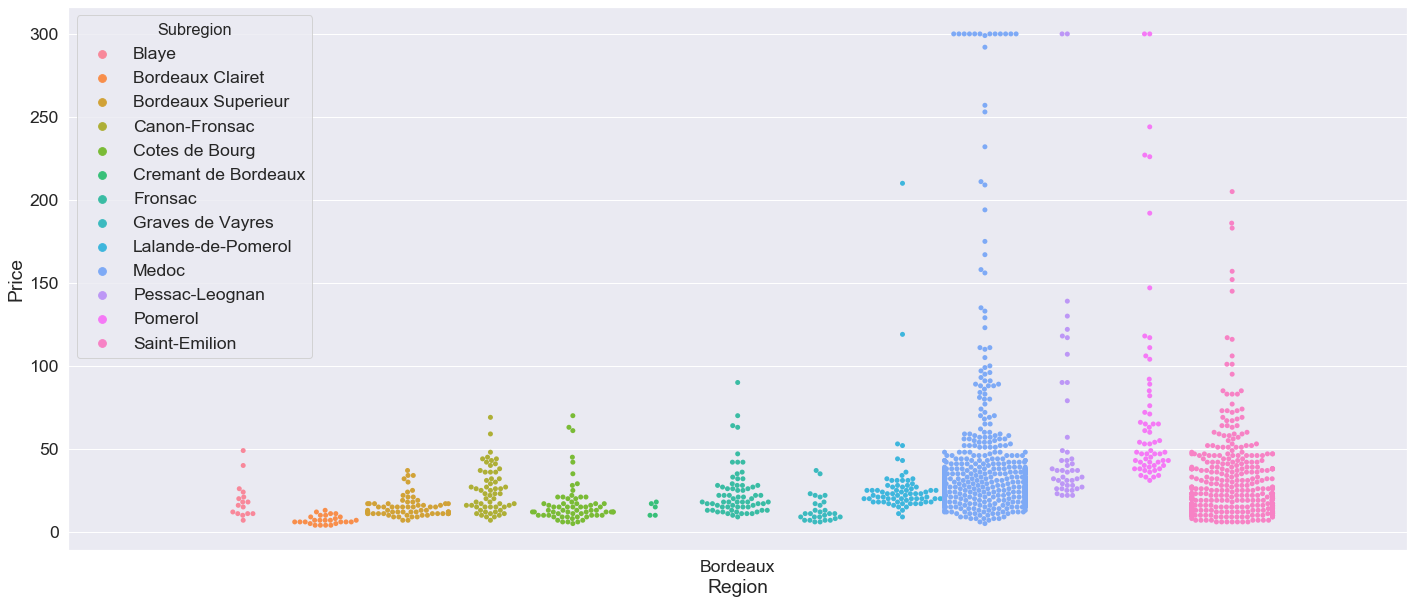

In [211]:
#single_dist(wine_df.loc[wine_df["Country"]=="France"], vars_=["Region", "PriceBucket"], type_=[0,0])
#french_wines_ = wine_df.loc[wine_df["Country"]=="France"]
single_dist(bordeaux_wines_.loc[bordeaux_wines_["Grape"].isin(["Bordeaux Blend Red"])], vars_=["Region", "Price"], type_=1, hue_="Subregion")

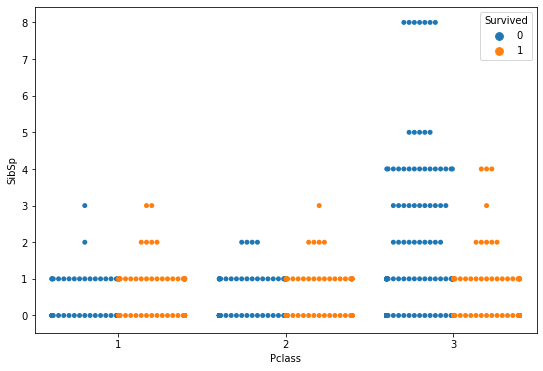

In [1381]:
single_dist(train_df, vars_=["Pclass", "SibSp"], type_=[0,1], hue_="Survived")

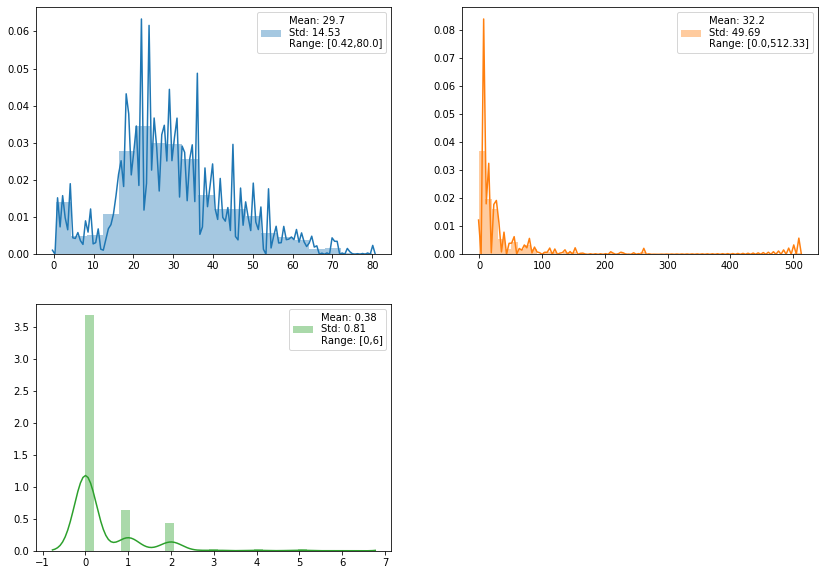

In [1085]:
multiple_dist(train_df, ["Age", "Fare", "Parch"], "Survived")

In [1134]:
train_df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
train_df = drop_null_cols(train_df, threshold=0.2)
train_df = drop_null_rows(train_df, ["Embarked"])
train_df = category_encode(train_df, ["Sex", "Embarked"], "ordinal")
train_df["Age"] = fill_null(train_df["Age"], lin_predict=train_df[["Pclass", "Age", "Sex", "SibSp",
                                                                   "Parch", "Fare", "Embarked"]])
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,1
1,1,1,2,38.000000,1,0,71.2833,2
2,1,3,2,26.000000,0,0,7.9250,1
3,1,1,2,35.000000,1,0,53.1000,1
4,0,3,1,35.000000,0,0,8.0500,1
...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,1
887,1,1,2,19.000000,0,0,30.0000,1
888,0,3,2,27.866658,1,2,23.4500,1
889,1,1,1,26.000000,0,0,30.0000,2


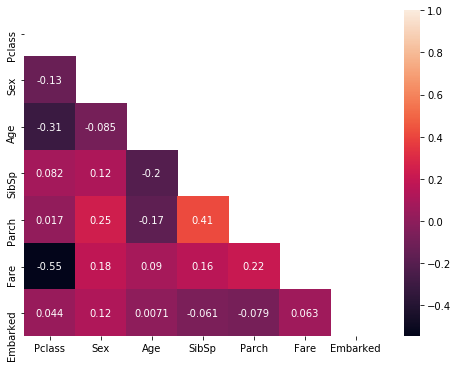

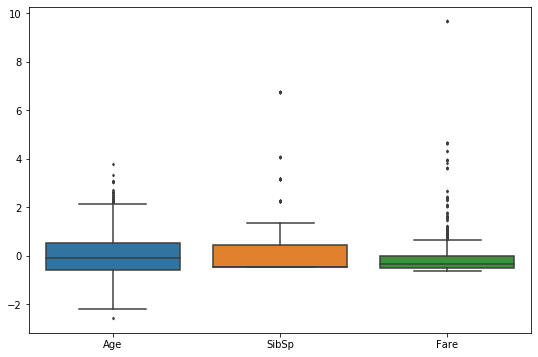

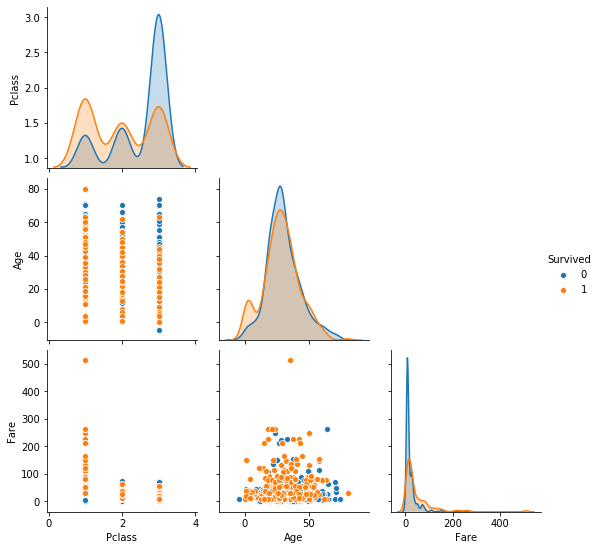

In [921]:
corr_ = corr_matrix(train_df, exclude_label="Survived")
outliers_ = box_plot(train_df[["Age", "SibSp", "Fare"]])
scatter_matrix(train_df, ["Pclass", "Age", "Fare"], "Survived")

In [ ]:
labels_ = total_df["Survived"]
features_ = total_df.drop(columns=["Survived"])
features_ = handle_outliers(features_, direction="Top", clip=False, z_thresh=3)
features_ = transform(features_, transform_=["","","standardize", "","","squareroot",""])
features_

In [ ]:
total_df = features_.merge(labels_, left_index=True, right_index=True)
total_df.reset_index(drop=True, inplace=True)
total_df

In [ ]:
distributions(total_df, ["Age", "Fare", "SibSp", "Pclass", "Parch"])

In [ ]:
train_df, val_df = train_test_split(total_df)
train_df_feat = train_df.drop(columns=["Survived"])
train_df_label = train_df[["Survived"]]
val_df_feat = val_df.drop(columns=["Survived"])
val_df_label = val_df[["Survived"]]

In [ ]:
total_df

In [ ]:
#test_df = pd.read_csv("../test.csv")
#test_df = category_encode(test_df, ["Sex", "Embarked"], "ordinal")
#test_df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
model = lgb.train(param, training, num_round, valid_sets=[validation], early_stopping_rounds=10, verbose_eval=False)
pred = model.predict(scale(val_df_feat))
score = roc_auc_score(val_df_label, pred)
print(f"Test AUC score: {score}")

In [ ]:
pipeline = make_pipeline(RandomForestRegressor(n_estimators=100))
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 
clf.fit(scale(train_df_feat), np.array(train_df_label).ravel())
pred = clf.predict(scale(val_df_feat))
print(r2_score(val_df_label, pred))
print(np.sqrt(mean_squared_error(val_df_label, pred)))

In [ ]:
clf = svm.SVC()
clf.fit(np.array(scale(train_df_feat)), np.array(train_df_label).ravel())
preds = clf.predict(np.array(scale(val_df_feat)))
score = roc_auc_score(np.array(val_df_label).ravel(), preds)
score

In [ ]:
scores = []
for neighbor_ in range(50,80):
    model = KNeighborsClassifier(n_neighbors=neighbor_, weights="distance")
    model.fit(np.array(scale(train_df_feat)), np.array(train_df_label).ravel())
    preds = model.predict(np.array(scale(val_df_feat)))
    score = roc_auc_score(np.array(val_df_label).ravel(), preds)
    scores.append([neighbor_, score])
scores = pd.DataFrame(scores, columns=["Neighbors", "Score"])
scores